In [68]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
    
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_perturbation, load_job, load_results, test_and_perturb, create_cdf_proportional_bins, rotate_by_angle

edges = create_cdf_proportional_bins(30, std_dev=1, range_multiplier=2.5)
centers = (edges[1:] + edges[:-1]) / 2

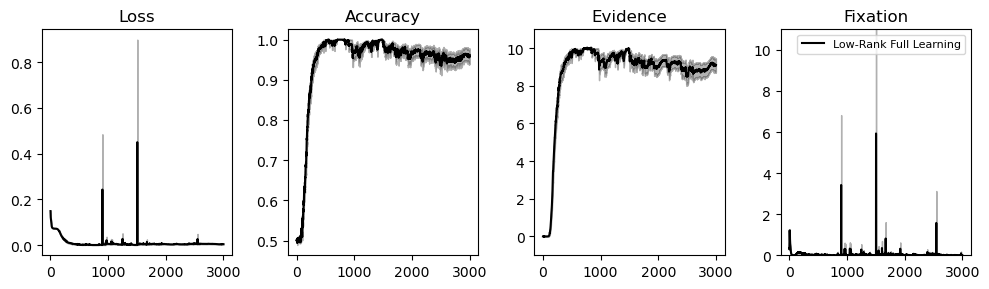

In [57]:
# Comparison of performance across different run types
jobs = [43, 44, 45, 46, 47]
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic"]
scale = [1, 1, 1, 1, 0.5]
keepjob = [True, False, False, False, False]
figure_name = "LearningComparison"
include_suffix = "_".join(["T" if keep else "F" for keep in keepjob])

loss = []
accuracy = []
evidence = []
fixation = []
for jobid, name in zip(jobs, names):
    train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)
    keep_idx = train_loss[:, -1] < np.inf
    loss.append(train_loss[keep_idx])
    accuracy.append(train_accuracy[keep_idx])
    evidence.append(train_evidence[keep_idx].detach())
    fixation.append(train_fixation[keep_idx].detach())

cols = 'krbgm'
fig, ax = plt.subplots(1, 4, figsize=(10, 3), tight_layout=True)
for ii in range(len(jobs)):
    if not keepjob[ii]:
        continue
    num_epochs = loss[ii].size(1)
    xepochs = np.array(range(num_epochs)) * scale[ii]
    lmean = loss[ii].mean(dim=0)
    lse = loss[ii].std(dim=0) / np.sqrt(loss[ii].size(0))
    amean = accuracy[ii].mean(dim=0)
    ase = accuracy[ii].std(dim=0) / np.sqrt(accuracy[ii].size(0))
    emean = evidence[ii].mean(dim=0)
    ese = evidence[ii].std(dim=0) / np.sqrt(evidence[ii].size(0))
    fmean = fixation[ii].mean(dim=0)
    fse = fixation[ii].std(dim=0) / np.sqrt(fixation[ii].size(0))
    ax[0].plot(xepochs, lmean, color=cols[ii], label=names[ii])
    ax[0].fill_between(xepochs, lmean - lse, lmean + lse, color=cols[ii], alpha=0.3)
    ax[1].plot(xepochs, amean, color=cols[ii], label=names[ii])
    ax[1].fill_between(xepochs, amean - ase, amean + ase, color=cols[ii], alpha=0.3)
    ax[2].plot(xepochs, emean, color=cols[ii], label=names[ii])
    ax[2].fill_between(xepochs, emean - ese, emean + ese, color=cols[ii], alpha=0.3) 
    ax[3].plot(xepochs, fmean, color=cols[ii], label=names[ii])
    ax[3].fill_between(xepochs, fmean - fse, fmean + fse, color=cols[ii], alpha=0.3)

ax[0].set_title("Loss")
# ax[0].set_ylim(0, 0.1)
# ax[0].set_yscale('log')
ax[1].set_title("Accuracy")


ax[2].set_title("Evidence")
ax[2].set_ylim(-1, 11)

ax[3].set_title("Fixation")
ax[3].set_ylim(0, 11)
ax[3].legend(fontsize=8)

plt.savefig(f"../project/{figure_name}_{include_suffix}")
plt.show()


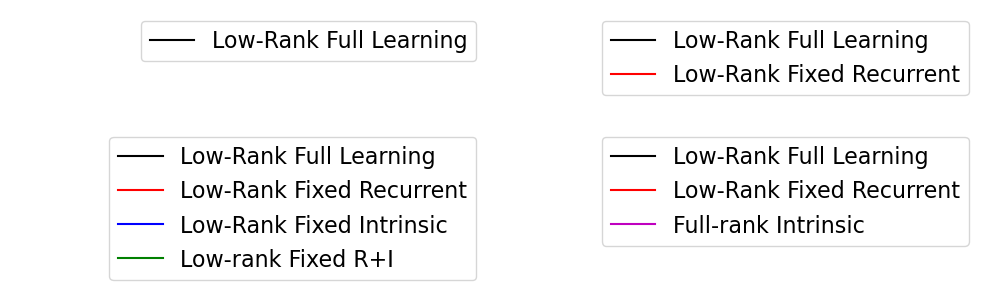

In [58]:
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic"]
to_plot = [[0], [0, 1], [0, 1, 2, 3], [0, 1, 4]]
fig, ax = plt.subplots(2, 2, figsize=(10, 3), tight_layout=True)
ax = np.reshape(ax, -1)
for ii in range(4):
    for jj in to_plot[ii]:
        ax[ii].plot([0, 0], [0, 0], c=cols[jj], label=names[jj])
    ax[ii].legend(fontsize=16)
    ax[ii].axis("off")

plt.savefig(f"../project/{figure_name}_legend")
plt.show()



torch.Size([39, 11, 5])
(tensor([9]),)
tensor([ True, False, False,  True,  True])


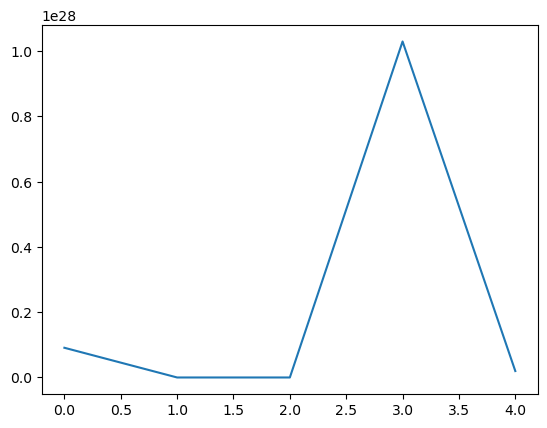

In [87]:
fixation[0].shape

avg_fixation = fixation[0].mean(dim=3)
print(avg_fixation.shape)


print(torch.where(torch.any(avg_fixation[:, 3, :] > 0.5e26, dim=1)))
print(torch.any(avg_fixation[:, 3, :] > 0.5e26, dim=0))

plt.close('all')
plt.plot(avg_fixation[9, 3, :])
plt.show()


[0, 1, 4]


5it [00:00, 203.89it/s]

torch.Size([39, 11, 128])
torch.Size([39, 11, 128])
torch.Size([34, 11, 128])



/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_15224/473283417.py:63: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[1, iplot].set_ylim(ylim)


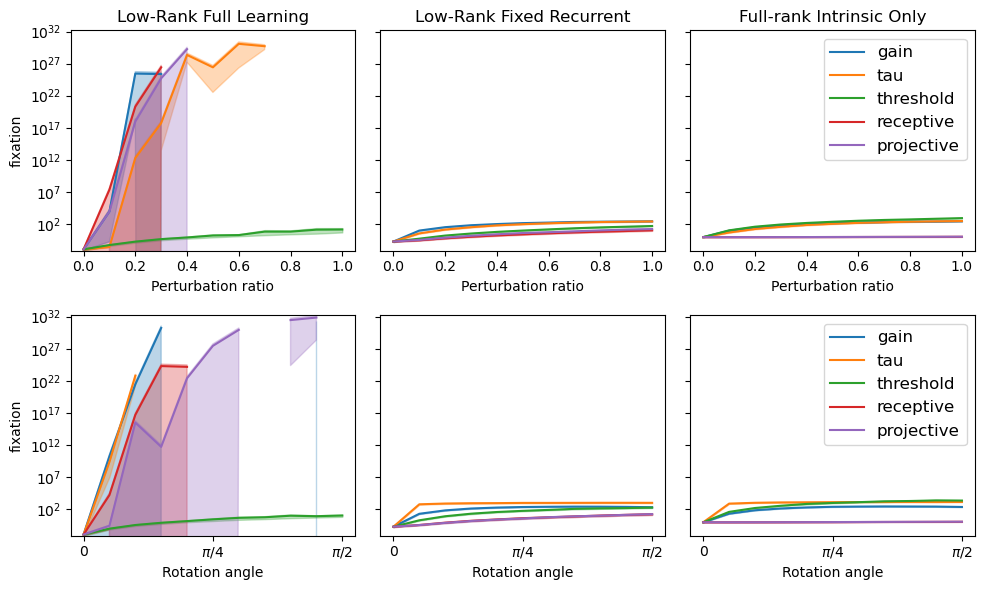

In [75]:
# Comparison of performance across different run types
jobs = [43, 44, 45, 46, 47]
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic Only"]
keepjob = [True, True, False, False, True]
idxplot = [i for i, keep in enumerate(keepjob) if keep]
figure_name = "PerturbationComparisonAccuracy"
include_suffix = "_".join(["T" if keep else "F" for keep in keepjob])

print(idxplot)

loss = []
accuracy = []
evidence = []
fixation = []
loss_rotate = []
accuracy_rotate = []
evidence_rotate = []
fixation_rotate = []

random_ratios = []
rotate_angles = [] 
for jobid, name in tqdm(zip(jobs, names)):
    perturb = load_perturbation(jobid, suffix="random")
    perturb_rotation = load_perturbation(jobid, suffix="rotation")
    loss.append(perturb["loss"])
    accuracy.append(perturb["accuracy"])
    evidence.append(perturb["evidence"].detach())
    fixation.append(perturb["fixation"].detach())
    loss_rotate.append(perturb_rotation["loss"])
    accuracy_rotate.append(perturb_rotation["accuracy"])
    evidence_rotate.append(perturb_rotation["evidence"].detach())
    fixation_rotate.append(perturb_rotation["fixation"].detach())
    random_ratios.append(perturb["perturb_ratios"])
    rotate_angles.append(perturb_rotation["perturb_ratios"])

show_perturb = [fixation, fixation_rotate]
evaluating = "fixation"
ylim = [None, None]
yscale = "log"

cmap = plt.get_cmap("tab10")
plt.close('all')
fig, ax = plt.subplots(2, len(idxplot), figsize=(10, 6), tight_layout=True, sharey=True, sharex="row")
for iplot, ii in enumerate(idxplot):
    for jj, target in enumerate(perturb["perturb_targets"]):
        if jj==0:
            print(accuracy[ii][:, :, jj].shape)
        amean = torch.nanmean(show_perturb[0][ii][:, :, jj], dim=(0, 2))
        ase = torch.std(torch.nanmean(show_perturb[0][ii][:, :, jj], dim=2), dim=0) / np.sqrt(show_perturb[0][ii].size(0))
        ax[0, iplot].plot(random_ratios[ii], amean, label=f"{target}", c=cmap(jj))
        ax[0, iplot].fill_between(random_ratios[ii], amean - ase, amean + ase, color=cmap(jj), alpha=0.3)
    for jj, target in enumerate(perturb["perturb_targets"]):
        amean = torch.nanmean(show_perturb[1][ii][:, :, jj], dim=(0, 2))
        ase = torch.std(torch.nanmean(show_perturb[1][ii][:, :, jj], dim=2), dim=0) / np.sqrt(show_perturb[1][ii].size(0))
        ax[1, iplot].plot(rotate_angles[ii], amean, label=f"{target}", c=cmap(jj))
        ax[1, iplot].fill_between(rotate_angles[ii], amean - ase, amean + ase, color=cmap(jj), alpha=0.3)
    ax[0, iplot].set_title(names[ii])
    ax[0, iplot].set_xlabel("Perturbation ratio")
    ax[1, iplot].set_xlabel("Rotation angle")
    ax[1, iplot].set_xticks([0, np.pi/4, np.pi/2], labels=["0", r"$\pi/4$", r"$\pi/2$"])
    ax[0, iplot].set_ylim(ylim)
    ax[0, iplot].set_yscale(yscale)
    ax[1, iplot].set_ylim(ylim)
    ax[1, iplot].set_yscale(yscale)
ax[0, -1].legend(fontsize=12)
ax[1, -1].legend(fontsize=12)
ax[0, 0].set_ylabel(evaluating)
ax[1, 0].set_ylabel(evaluating)
# plt.savefig(f"../project/{figure_name}_{evaluating}_{include_suffix}")
plt.show()


Keeping 40 out of 40


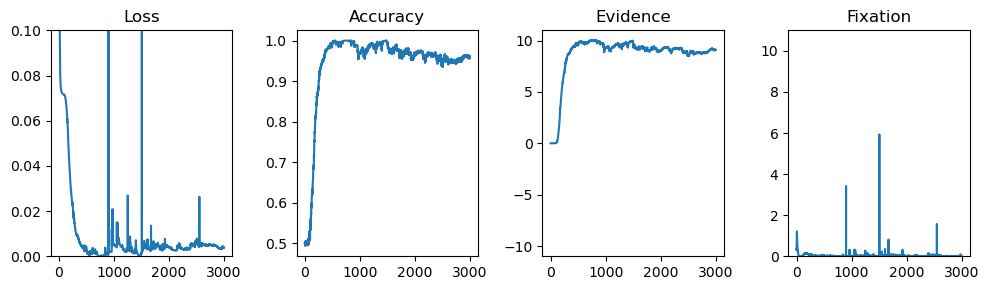

In [49]:
jobid = 43

train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)
keep_idx = train_loss[:, -1] < np.inf
print(f"Keeping {keep_idx.sum()} out of {keep_idx.shape[0]}")

train_evidence = train_evidence.detach()
train_fixation = train_fixation.detach()

fig, ax = plt.subplots(1, 4, figsize=(10, 3), tight_layout=True)
ax[0].plot(train_loss[keep_idx].mean(dim=0))
# ax[0].fill_between(range(train_loss.shape[1]), train_loss.mean(dim=0) - train_loss.std(dim=0), train_loss.mean(dim=0) + train_loss.std(dim=0), alpha=0.5)
ax[0].set_title("Loss")
ax[0].set_ylim(0, 0.1)

ax[1].plot(train_accuracy[keep_idx].mean(dim=0))
# ax[1].fill_between(range(train_accuracy.shape[1]), train_accuracy.mean(dim=0) - train_accuracy.std(dim=0), train_accuracy.mean(dim=0) + train_accuracy.std(dim=0), alpha=0.5)
ax[1].set_title("Accuracy")


ax[2].plot(train_evidence[keep_idx].mean(dim=0))
# ax[2].fill_between(range(train_evidence.shape[1]), train_evidence.mean(dim=0) - train_evidence.std(dim=0), train_evidence.mean(dim=0) + train_evidence.std(dim=0), alpha=0.5)
ax[2].set_title("Evidence")
ax[2].set_ylim(-11, 11)

ax[3].plot(train_fixation[keep_idx].mean(dim=0))
# ax[3].fill_between(range(train_fixation.shape[1]), train_fixation.mean(dim=0) - train_fixation.std(dim=0), train_fixation.mean(dim=0) + train_fixation.std(dim=0), alpha=0.5)
ax[3].set_title("Fixation")
ax[3].set_ylim(0, 11)

plt.show()

Low-Rank Fixed Recurrent
Keeping 40 out of 40


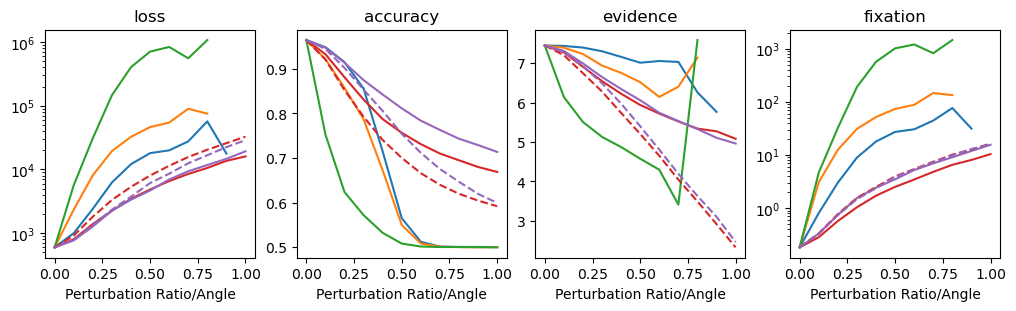

In [3]:
jobs = [43, 44, 45, 46, 47]
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic"]

jobid = 44
cjobname = names[jobs.index(jobid)]
print(cjobname)

train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)
keep_idx = train_loss[:, -1] < np.inf
print(f"Keeping {keep_idx.sum()} out of {keep_idx.shape[0]}")

perturb = load_perturbation(jobid, suffix="random")
perturb_rotation = load_perturbation(jobid, suffix="rotation")
perturb_ratios = perturb["perturb_ratios"]
psychometric_edges = perturb["psychometric_edges"]
perturb_targets = perturb["perturb_targets"]
psychometric_centers = (psychometric_edges[1:] + psychometric_edges[:-1]) / 2
model_indices = perturb["model_indices"]
keep_idx = keep_idx[:len(model_indices)]

loss = perturb["loss"][keep_idx]
accuracy = perturb["accuracy"][keep_idx]
evidence = perturb["evidence"][keep_idx]
fixation = perturb["fixation"][keep_idx]
psychometric = perturb["psychometric"][keep_idx]

perturb_rotation_angles = perturb_rotation["perturb_ratios"]
perturb_rotation_angles = perturb_rotation_angles / perturb_rotation_angles.max()

loss_rotation = perturb_rotation["loss"][keep_idx]
accuracy_rotation = perturb_rotation["accuracy"][keep_idx]
evidence_rotation = perturb_rotation["evidence"][keep_idx]
fixation_rotation = perturb_rotation["fixation"][keep_idx]
psychometric_rotation = perturb_rotation["psychometric"][keep_idx]

# Make nice lookup table of 5 colors so I can do color=cmap[index]
cmap = plt.get_cmap("tab10")

ylog = dict(loss=True, accuracy=False, evidence=False, fixation=True)

plt.close('all')
fig, ax = plt.subplots(1, 4, figsize=(10, 3), layout="constrained")
for ii, (name, value) in enumerate(zip(["loss", "accuracy", "evidence", "fixation"], [loss, accuracy, evidence, fixation])):
    for jj, target in enumerate(perturb_targets):
        ax[ii].plot(perturb_ratios, torch.nanmean(value[:, :, jj], dim=(0, 2)), label=f"{target}", c=cmap(jj))
for ii, (name, value) in enumerate(zip(["loss", "accuracy", "evidence", "fixation"], [loss_rotation, accuracy_rotation, evidence_rotation, fixation_rotation])):
    for jj, target in enumerate(perturb_targets):
        if target in ["receptive", "projective"]:
            ax[ii].plot(perturb_rotation_angles, torch.nanmean(value[:, :, jj], dim=(0, 2)), label=f"{target} (rotated)", linestyle="--", c=cmap(jj))
    ax[ii].set_title(name)
    ax[ii].set_xlabel("Perturbation Ratio/Angle")
    ax[ii].set_yscale("log" if ylog[name] else "linear")

savefig = False
if savefig:
    plt.savefig(f"../project/PerturbationComparison_{cjobname}")
plt.show()


# fig = plt.figure(figsize=(3, 3), tight_layout=True)
# for jj, target in enumerate(perturb_targets):
#     plt.plot([0, 0], [0, 0], label=f"{target}", c=cmap(jj))
# for jj, target in enumerate(perturb_targets):
#     if target in ["receptive", "projective"]:
#         plt.plot([0, 0], [0, 0], label=f"{target} (rotated)", linestyle="--", c=cmap(jj))
# plt.legend(fontsize=16)
# plt.axis("off")

# plt.savefig(f"../project/PerturbationComparison_legend")
# plt.show()





In [24]:
# Load trained model and results

jobid = 13
model_index = 9
model, results, init_model = load_job(jobid, model_index=model_index, init=True)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]
train_accuracy = results["train_accuracy"]
train_evidence = results["train_evidence"]
train_fixation = results["train_fixation"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
)
task.cursors = task_params["cursors"]

if args["network_type"] == "Gain":
    model_constructor = models.GainRNN
elif args["network_type"] == "Tau":
    model_constructor = models.TauRNN
elif args["network_type"] == "Full":
    model_constructor = models.FullRNN
else:
    raise ValueError("Unknown network type")

if args["network_type"] != "Full":
    kwargs = dict(input_rank=args["input_rank"], recurrent_rank=args["recurrent_rank"])
else:
    kwargs = {}

net = model_constructor(
    task.input_dimensionality(),
    args["num_neurons"],
    task.output_dimensionality(),
    **kwargs,
)

net.load_state_dict(model)

<All keys matched successfully>

In [33]:
# Generate random rotation matrix in 2D with specified angle
def rotation_matrix(angle):
    angle = torch.tensor(angle)
    return torch.tensor([[torch.cos(angle), -torch.sin(angle)], [torch.sin(angle), torch.cos(angle)]])

rm = rotation_matrix(0.1)

tensor([[ 0.9950, -0.0998],
        [ 0.0998,  0.9950]])


In [67]:
pnet = deepcopy(net)

do_perturb = True
rotation_angle = -0.5
perturb_type = "projective"
if do_perturb:
    rm = rotation_matrix(rotation_angle)
    if perturb_type == "intrinsic":
        gain_tau = torch.stack((pnet.hidden_gain.data.clone(), pnet.hidden_tau.data.clone()))
        new_gain_tau = torch.matmul(rm, gain_tau)
        pnet.hidden_gain.data = new_gain_tau[0]
        pnet.hidden_tau.data = new_gain_tau[1]
    elif perturb_type == "receptive":
        pnet.reccurent_receptive.data = torch.matmul(rm, pnet.reccurent_receptive.data.T).T
    elif perturb_type == "projective":
        pnet.reccurent_receptive.data = torch.matmul(rm, pnet.reccurent_receptive.data.T).T
    else:
        raise ValueError("Unknown perturbation type")

X, target, params = task.generate_data(1000, source_floor=0.5)
output, hidden = pnet(X, return_hidden=True)
output = output.detach()

choice, evidence, fixation = task.analyze_response(output)
choice_evidence = evidence[:, 1] - evidence[:, 0]
choice_evidence[params["labels"] == 0] *= -1
accuracy = (choice == params["labels"]).sum() / choice.size(0)
evidence = choice_evidence.mean()
fixation = fixation.mean()

print(accuracy, evidence, fixation)

# fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
# ax[0].plot(output[0].detach())
# ax[0].set_title("Output")
# ax[1].plot(hidden[0].detach())
# ax[1].set_title("Hidden")
# plt.show()


tensor(1.) tensor(8.5335) tensor(0.0029)


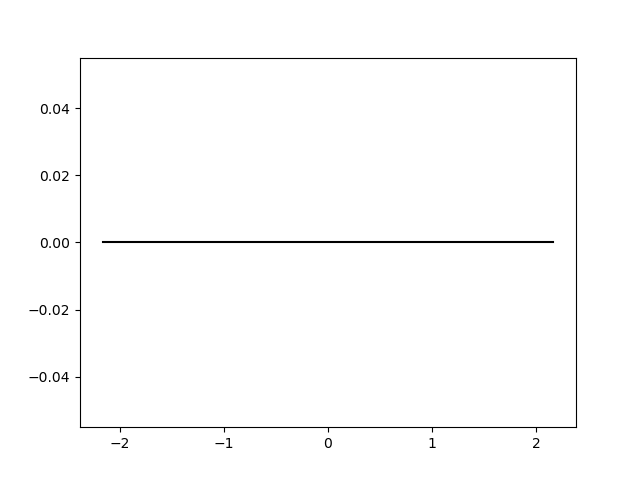

In [8]:
pnet = deepcopy(net)
pnet = pnet.to(device)

#perturb the model
# pnet.hidden_tau.data = pnet.hidden_tau.data + 0.0 * torch.randn_like(pnet.hidden_tau.data) * pnet.hidden_tau.data

X, target, params = task.generate_data(1000, source_floor=0.0)
s_target = torch.gather(params["s_empirical"], 1, params["context_idx"].unsqueeze(1)).squeeze(1)
outputs, hidden = pnet(X, return_hidden=True)
loss = nn.MSELoss(reduction="none")(outputs, target)
choice, evidence, fixation = task.analyze_response(outputs)


choice, evidence, fixation = task.analyze_response(outputs)
choice_evidence = evidence[:, 1] - evidence[:, 0]
choice_evidence[params["labels"] == 0] *= -1


s_index = torch.bucketize(s_target, edges)
psycho = torch.zeros(len(centers))
for i in range(len(centers)):
    if torch.sum(s_index == i) > 0:
        psycho[i] = torch.mean(choice[s_index == i].float())

plt.close('all')
plt.plot(centers, psycho, c='k', label="data")   
plt.show()

In [3]:
perturb_ratios = torch.linspace(0.5, 1, 2)
num_ratios = len(perturb_ratios)
num_trials = 10

loss_intrinsic = torch.zeros(num_ratios, num_trials)
loss_receptive = torch.zeros(num_ratios, num_trials)
loss_projective = torch.zeros(num_ratios, num_trials)

psychometric_edges = create_cdf_proportional_bins(30, std_dev=1, range_multiplier=2.5)
psychometric_centers = (psychometric_edges[1:] + psychometric_edges[:-1]) / 2

for i, perturb_ratio in enumerate(tqdm(perturb_ratios)):
    loss_intrinsic[i], x = test_and_perturb(net, task, psychometric_edges, perturb_ratio=perturb_ratio, perturb_target="intrinsic", num_trials=num_trials)
    loss_receptive[i], x = test_and_perturb(net, task, psychometric_edges, perturb_ratio=perturb_ratio, perturb_target="receptive", num_trials=num_trials)
    loss_projective[i], x = test_and_perturb(net, task, psychometric_edges, perturb_ratio=perturb_ratio, perturb_target="projective", num_trials=num_trials)

  0%|          | 0/2 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
ERROR:tornado.general:SEND Error: Host unreachable
100%|██████████| 2/2 [03:40<00:00, 110.44s/it]


In [161]:
perturb = load_perturbation(19, suffix="rotation")
perturb_ratios = perturb["perturb_ratios"]
psychometric_edges = perturb["psychometric_edges"]
psychometric_centers = (psychometric_edges[1:] + psychometric_edges[:-1]) / 2
model_indices = perturb["model_indices"]
loss_intrinsic = perturb["loss_intrinsic"]
loss_receptive = perturb["loss_receptive"]
loss_projective = perturb["loss_projective"]
accuracy_intrinsic = perturb["accuracy_intrinsic"]
accuracy_receptive = perturb["accuracy_receptive"]
accuracy_projective = perturb["accuracy_projective"]
evidence_intrinsic = perturb["evidence_intrinsic"]
evidence_receptive = perturb["evidence_receptive"]
evidence_projective = perturb["evidence_projective"]
fixation_intrinsic = perturb["fixation_intrinsic"]
fixation_receptive = perturb["fixation_receptive"]
fixation_projective = perturb["fixation_projective"]
psychometric_intrinsic = perturb["psychometric_intrinsic"]
psychometric_receptive = perturb["psychometric_receptive"]
psychometric_projective = perturb["psychometric_projective"]

tensor([0.0000, 0.1571, 0.3142, 0.4712, 0.6283, 0.7854, 0.9425, 1.0996, 1.2566,
        1.4137, 1.5708])


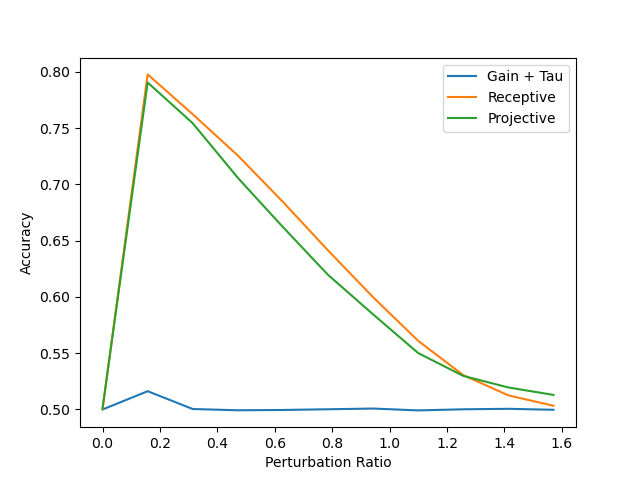

In [162]:
print(perturb_ratios)
plt.close('all')
plt.plot(perturb_ratios, torch.nanmean(accuracy_intrinsic, dim=(0, 2)), label="Gain + Tau")
plt.plot(perturb_ratios, torch.mean(accuracy_receptive, dim=(0, 2)), label="Receptive")
plt.plot(perturb_ratios, torch.mean(accuracy_projective, dim=(0, 2)), label="Projective")
plt.legend()
plt.xlabel("Perturbation Ratio")
plt.ylabel("Accuracy")
plt.show()

tensor(0.1000)


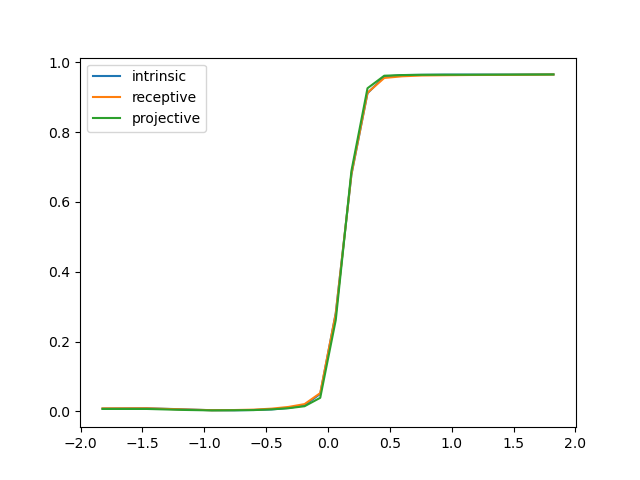

In [3]:
ii = 1
print(perturb_ratios[ii])
plt.close('all')
plt.plot(psychometric_centers, torch.mean(psychometric_intrinsic, dim=0)[ii], label="intrinsic")
plt.plot(psychometric_centers, torch.mean(psychometric_receptive, dim=0)[ii], label="receptive")
plt.plot(psychometric_centers, torch.mean(psychometric_projective, dim=0)[ii], label="projective")
plt.legend()
plt.show()

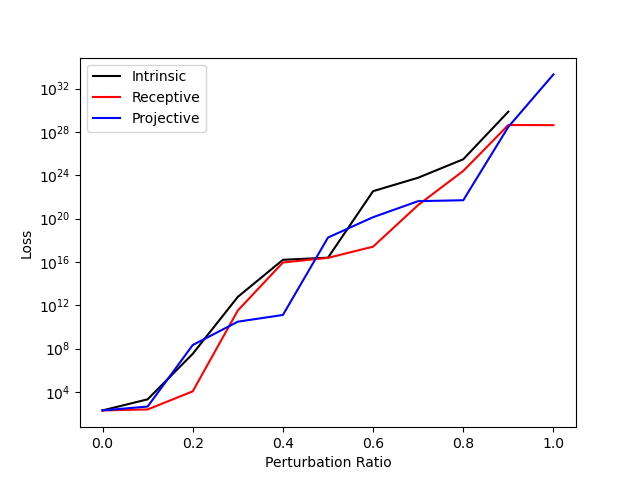

In [24]:
cols = 'krb'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(perturb_ratios, loss_intrinsic.mean(dim=(0, 2)), label="Intrinsic", c=cols[0])
ax.plot(perturb_ratios, loss_receptive.mean(dim=(0, 2)), label="Receptive", c=cols[1])
ax.plot(perturb_ratios, loss_projective.mean(dim=(0, 2)), label="Projective", c=cols[2])
# ax.fill_between(perturb_ratios, loss_intrinsic.mean(dim=1) - loss_intrinsic.std(dim=1), loss_intrinsic.mean(dim=1) + loss_intrinsic.std(dim=1), alpha=0.5, color=cols[0])
# ax.fill_between(perturb_ratios, loss_receptive.mean(dim=1) - loss_receptive.std(dim=1), loss_receptive.mean(dim=1) + loss_receptive.std(dim=1), alpha=0.5, color=cols[1])
# ax.fill_between(perturb_ratios, loss_projective.mean(dim=1) - loss_projective.std(dim=1), loss_projective.mean(dim=1) + loss_projective.std(dim=1), alpha=0.5, color=cols[2])
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Perturbation Ratio")
ax.set_ylabel("Loss")
ax.legend()
plt.show()